# We will find the best product for you based on the product and the necessary feature you provide as input
<hr>

## How are we going to do?

<ul>
<li><b> Extact reviews of few products based on your requirement</b></li>
<li><b> Apply Sentiment Analysis</b></li>
<li><b> Suggest most suitable product Name</b></li>
</ul>


In [25]:
################# NO NEED #################
from bs4 import BeautifulSoup
import requests
from lxml import html

In [26]:
################# NO NEED #################
userInput='headphones noise cancellation'
url_amzn = 'https://www.amazon.in/s/ref=nb_sb_noss_2?url=search-alias%3Daps&field-keywords=' + userInput
print(url_amzn)

https://www.amazon.in/s/ref=nb_sb_noss_2?url=search-alias%3Daps&field-keywords=headphones noise cancellation


In [50]:
import pandas as pd 
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

In [51]:
# Read CSV files associated with the three products

amz_reviews1 = pd.read_csv("amazon.csv")
amz_reviews2 = pd.read_csv("sony_review.csv")
amz_reviews3 = pd.read_csv("jbl_review.csv")

In [52]:
# sneak peek of dataset 1 
# Each row corresponds to a single review given by product user

amz_reviews1.head()

,Ratings,Review_body,Date,Review_head
0,3.0 out of 5 stars,overall the quality music is awesome never had...,Reviewed in India on 14 August 2020,NOT THE BEST BLUETOOTH MODE HEADPHONE
1,2.0 out of 5 stars,"1. Anything you listen, even at 50% volume, is...",Reviewed in India on 21 August 2020,stay away!!
2,1.0 out of 5 stars,\n Noise cancellation doesn't work in this pr...,Reviewed in India on 19 August 2020,"Quality is not good , NO noise cancellation fe..."
3,5.0 out of 5 stars,"I have heard many headphones, but i choose ver...",Reviewed in India on 27 July 2020,Great and value for money product.
4,5.0 out of 5 stars,Battery Backup:\n10/10\nSound quality:\n10/10\...,Reviewed in India on 24 September 2020,Best value for money !!


In [4]:
# sneak peek of dataset 2 

amz_reviews2.head()

,Ratings,Review_body,Date,Review_head
0,4.0 out of 5 stars,Update sept 26\n\nGot the replacement set and ...,Reviewed in India on 20 September 2020,"As someone else in this review section said "" ..."
1,4.0 out of 5 stars,"After a very slow delivery by Amazon, it came ...",Reviewed in India on 28 September 2020,Not that great for the price
2,5.0 out of 5 stars,This is a great piece of headphone.\n\nReason ...,Reviewed in India on 24 September 2020,When you need to listen and when don't need to !!
3,5.0 out of 5 stars,So much is already said about these headphones...,Reviewed in India on 27 September 2020,Best of two worlds
4,5.0 out of 5 stars,Sony....you made my day❤️ What a masterpiece S...,Reviewed in India on 20 September 2020,SONY made a MASTERPIECE ❤️❤️


In [5]:
# sneak peek of dataset 3

amz_reviews3.head()

,Ratings,Review_body,Date,Review_head
0,1.0 out of 5 stars,"Day 1: Headphones came, sounds great, google ...",The manufacturer commented on the review below,Please dont buy if you face these circumstances
1,5.0 out of 5 stars,I was quite skeptical before buying this consi...,Reviewed in India on 7 October 2019,Great buy. Amazing Budget active Noise Cancell...
2,5.0 out of 5 stars,Firstly i hv many headphones and earphones lik...,Reviewed in India on 20 June 2019,Exceptional at this price point! Blindly go fo...
3,4.0 out of 5 stars,Do not expect really high noise cancellation f...,Reviewed in India on 30 July 2019,"Budget OENC headset, overall good product at t..."
4,5.0 out of 5 stars,Simply the best in this price.\nThe bass is go...,Reviewed in India on 3 July 2019,Great product.


In [53]:
print(amz_reviews1.shape)
print(amz_reviews2.shape)
print(amz_reviews3.shape)
amz_reviews1.columns

(38, 4)
(178, 4)
(101, 4)


Index(['Ratings', 'Review_body', 'Date', 'Review_head'], dtype='object')

In [162]:
#columns = amz_reviews[ 'Review_body']
#columns=list(columns)
#print(columns)

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings("ignore")
import re

### Sentiment analysis

In [56]:
# Sentiment Analysis without using the built-in tool

'''
-----------------------------------------------------------------------------------------------------------------------

Procedure:
1.Remove numbers, characters and white spaces from reviews
2.If review has 'not' replace 'not' and the next word together with an Antonym
3.Find the sentiScore for each word after tokenization
4.Using above find the sentiScore of the sentence
            
-----------------------------------------------------------------------------------------------------------------------

*******delete below later*******
Synset instances are the groupings of synonymous words that express the same concept.

flow for below code:
preprocess -> tokenize -> POS tagging -> Replace Antonym 

-----------------------------------------------------------------------------------------------------------------------

'''

class AntonymReplacer(object):
    def replace(self, word):
        ant = list()
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    ant.append(lemma.antonyms()[0].name())
        if len(ant) >= 1:
            return ant[0]
        else:
            return None

    def negreplace(self, string):
        i = 0
        sent = word_tokenize(string)
        len_sent = len(sent)
        words = []
        while i < len_sent:
            word = sent[i]
            if word == 'not' and i + 1 < len_sent:
                ant = self.replace(sent[i + 1])
                if ant:
                    words.append(ant)
                    i += 2
                    continue
            words.append(word)
            i += 1
        return words

lemmatizer = WordNetLemmatizer()


def penn_to_wn(tag):
    
    #Convert between the PennTreebank tags to simple Wordnet tags
    
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


def swn_polarity(text):    

    sentiment = 0.0
    tokens_count = 0
    b = ""
    if "not" in text:
        x = ""
        raw_sentences = sent_tokenize(text)
        for raw_sentence in raw_sentences:
            tagged_sentence = pos_tag(word_tokenize(raw_sentence))

            for word, tag in tagged_sentence:
                wn_tag = penn_to_wn(tag)
                if wn_tag in (wn.NOUN, wn.ADJ):
                    x = x + " " + word
                elif word == 'not':
                    x = x + " " + word
                else:
                    continue
        rep = AntonymReplacer()
        a = rep.negreplace(x)
        for i in range(len(a)):
            b = b + " " + str(a[i])
            
    if b == "":
        b = text
    
    raw_sentences = sent_tokenize(b)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))

        for word, tag in tagged_sentence: 
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue

            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue

            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue

           
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())

            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
    return sentiment



def preprocessing(reviews_list):
    score=[]
    for j in range(0,len(reviews_list)):
        paragraph =reviews_list[j] 
        
        #removing numbers
        paragraph = re.sub(r'\[[0-9]*\]', ' ', paragraph)
        
        #removing duplicate white spaces
        paragraph = re.sub(r'\s+', ' ', paragraph)  
        paragraph
        
        #removing all characters except a-z and A-Z
        formatted_paragraph = re.sub('[^a-zA-Z]', ' ', paragraph )
        
        #removing duplicate white spaces
        formatted_paragraph = re.sub(r'\s+', ' ', formatted_paragraph)  
        formatted_paragraph
        
        num = swn_polarity(paragraph)
        score.append(num)
        #print(num)

    print(score)
    print('-----------------')
    
    value=[]
    for i in score:
        if i >= 0.5:
            value.append('pos')
        elif (i > -0.5) and (i < 0.5):
            value.append( 'neu')
        else:
            value.append ('neg')
    return(value)

In [57]:
# Producing sentiment score for each review of Dataset1

reviews_list1=amz_reviews1['Review_body']
s1=preprocessing(reviews_list1)
print(s1)


[-1.375, -1.25, -1.75, 1.375, 3.125, 1.875, 3.75, 3.125, 1.25, 1.5, 0.0, 4.0, 2.875, 3.75, 2.0, 1.0, 1.625, 2.75, 2.5, -0.625, 3.125, 0.5, 0.5, 0.0, 1.125, 2.5, 2.375, -0.25, 0.5, 0.75, 0.125, -0.25, -0.625, 1.875, 0.75, 0.0, -0.25, 1.125]
-----------------
['neg', 'neg', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'neu', 'neu', 'neg', 'pos', 'pos', 'neu', 'neu', 'pos']


In [44]:
# Calculating percentage of positive reviews in dataset1 for later comparison of products

percent1=((s1.count('pos')/len(s1))*100)
print(percent1)
totalPos=s1.count('pos')+s1.count('neu')
print('Positive reviews: ', totalPos,'/',len(s1))

59.09090909090909
Positive reviews:  33 / 44


In [45]:
# Producing sentiment score for each review of Dataset2

reviews_list2=amz_reviews2['Review_body']
s2=preprocessing(reviews_list2)
print(s2)

[7.75, -1.5, 3.875, 1.75, 1.625, 0.25, 1.0, -1.25, 0.0, -0.25, 1.375, 2.375, 2.125, 0.75, 1.375, -0.625, -0.875, 4.125, -1.125, -1.5, 5.125, 1.625, -1.625, -4.625, -0.25, -9.0, -2.5, 0.25, -2.0, -1.5, -1.5, -0.25, 0.0, 1.0, -1.375, 2.0, -0.625, 0.75, 2.625, 4.0, 1.5, 11.625, 3.625, -0.5, -0.125, -1.25, 3.0, -1.25, -1.125, -1.125, 3.625, -0.75, 13.875, 0.25, 0.75, -0.125, 2.5, 2.625, -0.125, -0.5, 2.375, 2.625, 5.125, 1.625, 4.0, 4.5, 1.0, -1.0, 5.625, 6.25, 1.875, 1.375, -3.0, 2.625, 1.0, 2.25, 7.625, 3.25, 0.625, 4.25, -6.375, -5.5, 2.125, -1.875, 1.875, 2.625, 1.25, 0.25, 0.375, -0.125, -2.5, -2.75, 1.0, 1.25, 0.875, -3.875, 0.625, -2.75, -1.0, -2.75, -4.25, 2.125, 2.125, -1.5, -1.5, 3.25, 3.625, 1.75, -0.375, 0.875, 0.625, 0.125, 3.25, -0.25, 3.375, -1.125, 1.5, 0.75, 0.625, 3.25, 2.0, 2.0, 4.375, 0.75, 0.625, 1.0, 2.25, -0.75, 0.875, 1.375, -1.25, 4.625, -1.375, 1.625, 1.875, 1.5, 1.0, 1.0, 0.0, 1.25, 1.75, 1.125, 1.375, 0.625, 0.0, 1.375, 0.625, 1.625, -0.875, 0.75, 0.875, -0.625,

In [46]:
# Calculating PERCENTAGE of positive reviews in DATASET2 for later comparison of products

percent2=((s2.count('pos')/len(s2))*100)
print(percent2)
totalPos=s2.count('pos')+s2.count('neu')
print('Positive reviews: ', totalPos,'/',len(s2))

62.35955056179775
Positive reviews:  134 / 178


In [47]:
# Producing sentiment score for each review of Dataset3

reviews_list3=amz_reviews3['Review_body']
s3=preprocessing(reviews_list3)
print(s3)

[-0.625, 4.125, 2.75, 0.25, 4.25, 6.0, 2.125, 1.5, 1.625, -2.0, 0.25, 1.875, 1.125, 1.25, -0.5, -0.25, 2.875, -2.125, 1.25, 1.5, -0.375, 2.25, 2.625, 2.5, 4.625, -1.625, -0.75, 2.125, 0.978, 0.625, 3.5, 0.875, 0.625, 0.0, 2.75, 1.5, 1.625, 1.125, 1.25, -2.625, -2.125, 0.125, -0.375, 2.375, 1.75, -1.125, 0.5, 0.625, 2.625, 0.75, 2.625, 0.0, 3.125, 1.75, 0.375, 2.0, 0.375, 1.25, 1.125, 0.0, 1.875, 0.375, 2.125, 0.375, -0.25, 1.0, -0.625, 0.125, 0.75, 11.875, 7.444, 1.625, 4.125, 1.75, 1.75, 2.125, 0.5, -1.0, -0.625, 1.5, -0.625, 3.625, -1.375, 1.0, -0.875, -0.625, 0.625, 1.75, 1.5, 0.0, 0.0, 4.25, 0.875, 1.625, -0.875, 3.125, 0.875, -1.125, 2.125, 3.625, -0.125]
-----------------
['neg', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neu', 'pos', 'pos', 'pos', 'neg', 'neu', 'pos', 'neg', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'neu', 'neu', 'pos', 'pos

In [48]:
# Calculating PERCENTAGE of positive reviews in DATASET3 for later comparison of products

percent3=((s3.count('pos')/len(s3))*100)
print(percent3)
totalPos=s3.count('pos')+s3.count('neu')
print('Positive reviews: ', totalPos,'/',len(s3))

64.35643564356435
Positive reviews:  83 / 101


In [171]:
################# NO NEED ####################
# VADER sentiment analysis tool for getting Compound score.
def sentimental(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    return score


# VADER sentiment analysis tool for getting pos, neg and neu.
def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'


    
#reviews_list.apply(lambda x: sentimental_Score(x))
res=list(map(sentimental_Score,reviews_list))
print(res)

['pos', 'neg', 'neu', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'neu', 'neu', 'pos', 'pos', 'pos', 'pos', 'neu', 'neu', 'neu', 'pos', 'neu', 'pos', 'neu', 'neu', 'pos', 'neu']


###         Final output 

In [66]:
# Deciding which product is most suitable based on percentage of maximum positive reviews

#print(max(percent1,percent2,percent3))
if (max(percent1,percent2,percent3)==percent1):
    print('Ayy this PRODUCT1 is for u only, pandaga chesko ;)')
elif (max(percent1,percent2,percent3)==percent2):
    print('Ayy "JBL LIVE 650BTNC" (PRODUCT2) is for u only, pandaga chesko ;)')
else:  print('Ayy "SONY 100 XM3" (PRODUCT3) is for u only, pandaga chesko ;)')

Ayy "SONY 100 XM3" (PRODUCT3) is for u only, pandaga chesko ;)


# Word Cloud Generation

In [28]:
'''
To Generate a word corpus following steps are performed inside the function 'create_Word_Corpus(df)'

Step 1 :- Iterating over the 'summary' section of reviews such that we only get important content of a review.
Step 2 :- Converting the content into Lowercase.
Step 3 :- Using nltk.tokenize to get words from the content.
Step 4 :- Using string.punctuation to get rid of punctuations.
Step 5 :- Using stopwords from nltk.corpus to get rid of stopwords.
Step 6 :- Stemming of Words.
Step 7 :- Finally forming a word corpus and returning the word corpus.
'''

#Stemming of different form of words which will be used by 'create_Word_Corpus()' function
def stemming(tokens):
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words


def create_Word_Corpus(df):
    words_corpus = ''
    for val in df:
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus

In [29]:
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [30]:
# Function to segregate all positive and negative reviews 

def collectPos(res,s):
    pos=[]
    for i in range(0,len(res)):
        if s[i]=='pos':
            pos.append(res[i])
    return pos

def collectNeg(res,s):
    neg=[]
    for i in range(0,len(res)):
        if s[i]=='neg':
            neg.append(res[i])
    return neg

In [31]:
# Extracting all Reviews from DATASET1  into list 

columns1 = amz_reviews1[ 'Review_body']
columns1=list(columns1)
print(columns1)
print("---------------------")

["overall the quality music is awesome never had such experience in other headphones\nI would recommend buying this,\n\nCONS:\n1. The Bluetooth is not so strong to hear a song in a terrace, audio breaks like anything\nin a closed room, u won't find anything like a break-in the signal\n2. The aux cable is totally not lengthy not suitable for PUBG like games Bluetooth audio is slow for games\nand aux is not fitted properly and it's not a dependent one\n\nPROS:\n1. good audio, awesome everything to hear and noise cancellation is really good", '1. Anything you listen, even at 50% volume, is audible to people in other room as well. They should be categorized as mini speakers rather than headphones\n2. Aux cable provided in the box is too short for using with laptop/computer\n3. Even with music playing, we can hear everything (zero noise cancellation)\n\nWorst product and note that there is no refund for this item => you end up with same piece again!', "\n  Noise cancellation doesn't work in

In [32]:
# Extracting all Reviews from DATASET2 into list 

columns2 = amz_reviews2[ 'Review_body']
columns2=list(columns2)
print(columns2)
print("---------------------")
#print(s1)

['Update sept 26\n\nGot the replacement set and they sound do much better than the first ones I recieved. This kind of issues is unheard of from a product that costs 30k not gonna lie. Seriosuly? A defective pair of headphones ? Unexpected sony !\n\nUpdate- sept-25\n\nSo I was using these like.usual when I started hearing a shrill noise from the right side earcup! Tried it with multiple devices , persistsnt shrill noise with noise cancelion and no music( my room\'s fan was off ) . Replacing for a new pair . Will update\n\nI\'m not a "audiophile" but I\'ve tested and heard many headphones/earphones in search of the "perfect" pair of cans for me. Perfect is a subjective term and will vary from person to person.\n\nI bought these becasue of all the hype with the xm3\'s and as a customer the "next" version would obviously be better right ?\n\nSo, come delivery day. I ooened these, set them up, updated the firmware and started listening . These sound , ok. For something that costs 30k, thes

In [33]:
# Extracting all Reviews from DATASET3 into list 

columns3 = amz_reviews3[ 'Review_body']
columns3=list(columns3)
print(columns3)
print("---------------------")
#print(s2)

["Day 1:  Headphones came, sounds great, google assistant works greatDay 10:  Battery backup reduces even after without noise cancellation activatedDay 12:  The bass sounds distorted (but I build the tolerance)Day 15:  Headphones misbehaving, Automatically turns on and gets connected to the nearest paired deviceDay 16:  Headphones stops chargingDon't know what to do next", "I was quite skeptical before buying this considering the price and Noise cancelation quality. Guess what, it turned out to be a great decision putting money in this buy.\nJBL 650BT Live is an excellent active Noise cancellation headset. It delivers an optimum sound quality. Plus you get inbuilt Google assistant and Alexa to do your chores. It can read out notifications, call or message someone, set a reminder and many more, all you've to say ok Google or Alexa. I've been using it for 3months, here is my review. I've been using spotify to listen songs and results are amazing.\n\nPros:\nGood active noise cancellation.

In [34]:
# Collecting all reviews in list all_reviews

all_reviews=columns1
all_reviews.append(columns2)
all_reviews.append(columns3)
#print(len(all_reviews))
print(all_reviews)

["overall the quality music is awesome never had such experience in other headphones\nI would recommend buying this,\n\nCONS:\n1. The Bluetooth is not so strong to hear a song in a terrace, audio breaks like anything\nin a closed room, u won't find anything like a break-in the signal\n2. The aux cable is totally not lengthy not suitable for PUBG like games Bluetooth audio is slow for games\nand aux is not fitted properly and it's not a dependent one\n\nPROS:\n1. good audio, awesome everything to hear and noise cancellation is really good", '1. Anything you listen, even at 50% volume, is audible to people in other room as well. They should be categorized as mini speakers rather than headphones\n2. Aux cable provided in the box is too short for using with laptop/computer\n3. Even with music playing, we can hear everything (zero noise cancellation)\n\nWorst product and note that there is no refund for this item => you end up with same piece again!', "\n  Noise cancellation doesn't work in

In [58]:
# Collecting all pos and neg tags 

s_all=s1
s_all.append(s2)
s_all.append(s3)
print(s_all)

['neg', 'neg', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'pos', 'neu', 'pos', 'pos', 'neu', 'neu', 'neg', 'pos', 'pos', 'neu', 'neu', 'pos', ['pos', 'neg', 'pos', 'pos', 'pos', 'neu', 'pos', 'neg', 'neu', 'neu', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg', 'neu', 'neg', 'neg', 'neu', 'neg', 'neg', 'neg', 'neu', 'neu', 'pos', 'neg', 'pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neu', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'neu', 'pos', 'neu', 'pos', 'pos', 'neu', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'pos', 'pos', 'pos', 'neu', 'neu', 'neu', 'neg', 'neg', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg

In [38]:
# calling function collectPos and collectNeg to complete segregation of positive and negative reviews 

pos=collectPos(all_reviews,s_all)
neg=collectNeg(all_reviews,s_all)

In [39]:
print(pos)

['I have heard many headphones, but i choose very wisely.\n\nI love this over the ear headphones with a theatre kind of feeling with noise cancellation.\n\nAlso one more good good thing is, it comes up with wire if incase battery of bluetooth is not available.\n\nThey also call once for support and feedback which i think no headphone company does.', "Battery Backup:\n10/10\nSound quality:\n10/10\nBass:\n9.5/10\nBuild:\n9.5/10\nComfort:\n9.5/10\nPackaging was very good. Light weight & Battery backup is commendable. I use it for 4 - 5 hrs continuously, but battery reduction was minimal.\nVery good audio quality with passive noise cancellation. Microphone is also very effective with clear sound. Worth every penny. Just go for it. you'll love it.\nOverall, best value for money !!", "\n  I am Boult audio thunder user and I am fully satisfied by this product. The notice cancellation is good but then too you can hear loud noises of vehicles. The sound quality is better. The battery life for b

In [40]:
print(neg)

["overall the quality music is awesome never had such experience in other headphones\nI would recommend buying this,\n\nCONS:\n1. The Bluetooth is not so strong to hear a song in a terrace, audio breaks like anything\nin a closed room, u won't find anything like a break-in the signal\n2. The aux cable is totally not lengthy not suitable for PUBG like games Bluetooth audio is slow for games\nand aux is not fitted properly and it's not a dependent one\n\nPROS:\n1. good audio, awesome everything to hear and noise cancellation is really good", '1. Anything you listen, even at 50% volume, is audible to people in other room as well. They should be categorized as mini speakers rather than headphones\n2. Aux cable provided in the box is too short for using with laptop/computer\n3. Even with music playing, we can hear everything (zero noise cancellation)\n\nWorst product and note that there is no refund for this item => you end up with same piece again!', "\n  Noise cancellation doesn't work in

In [41]:
# Creating Word Cloud

pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

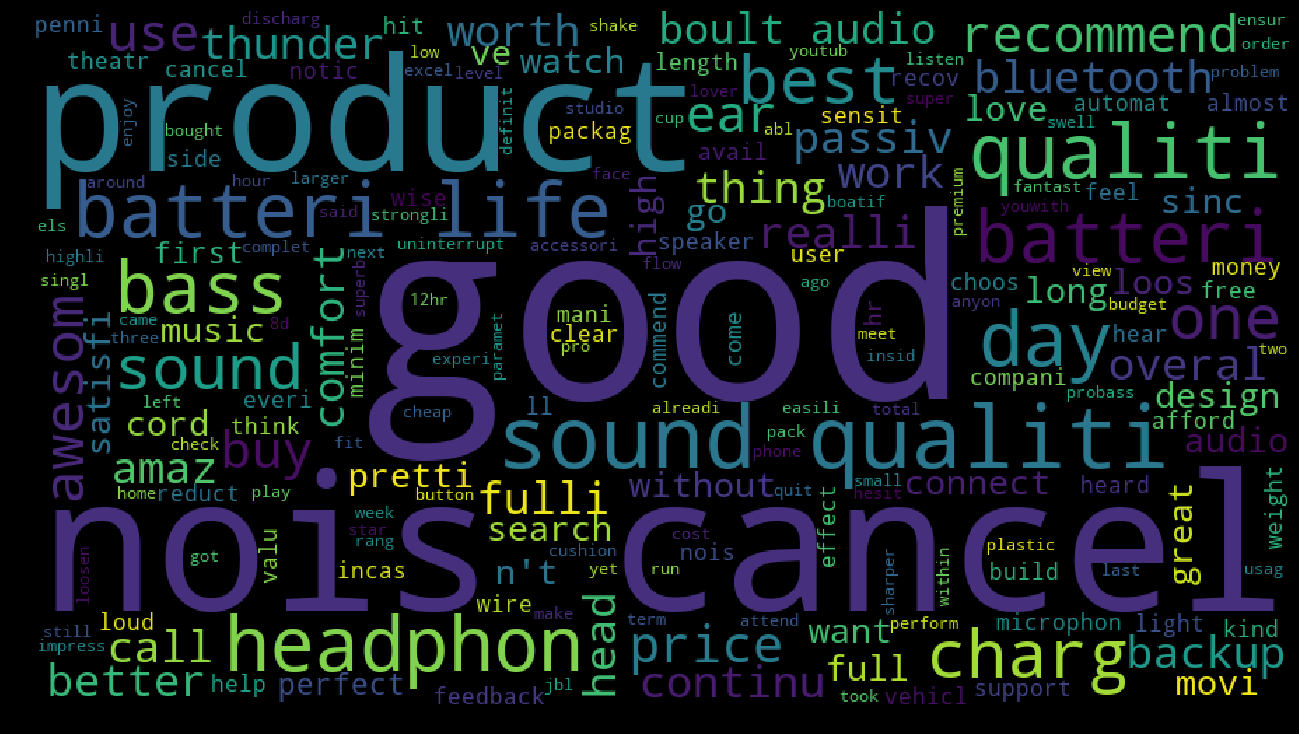

In [42]:
# Word cloud for positive Reviews

plot_Cloud(pos_wordcloud)

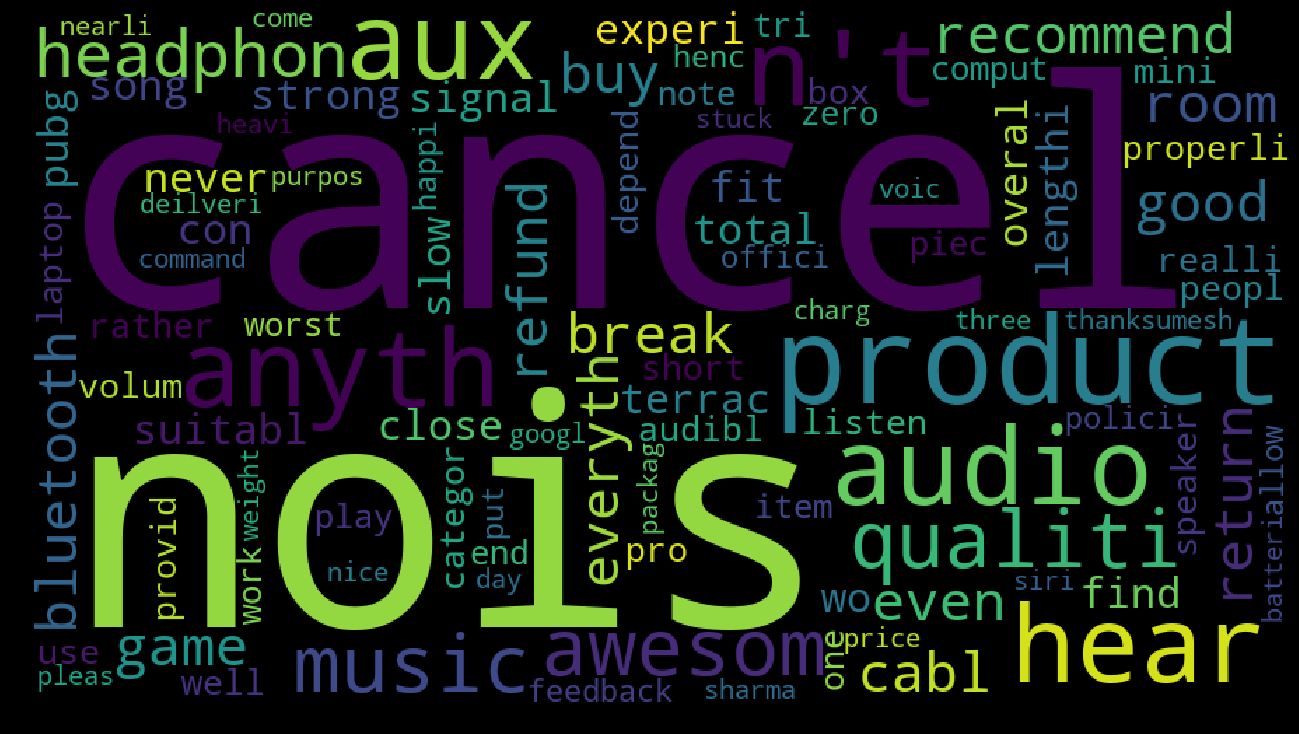

In [43]:
# Word cloud for negative Reviews

plot_Cloud(neg_wordcloud)